In [3]:
!pip install rasterio geopandas

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize

In [5]:
df = gpd.read_file('/kaggle/input/deforestation-in-ukraine/deforestation_labels.geojson')
df

img_date   tile                                           geometry
0     2016-04-09  36UXA  POLYGON ((35.79130 50.17406, 35.79277 50.17354...
1     2016-04-09  36UXA  POLYGON ((35.77653 50.10271, 35.77810 50.10318...
2     2016-04-09  36UXA  POLYGON ((35.78621 50.01277, 35.78616 50.01369...
3     2016-04-09  36UXA  POLYGON ((35.78007 50.00556, 35.78189 50.00557...
4     2016-04-09  36UXA  POLYGON ((35.79781 49.99568, 35.79908 49.99582...
...          ...    ...                                                ...
5691  2019-09-09  36UYA  POLYGON ((36.37494 50.17378, 36.37506 50.17376...
5692  2019-09-09  36UYA  POLYGON ((36.37849 50.17354, 36.37851 50.17352...
5693  2019-09-09  36UYA  POLYGON ((35.91477 50.22407, 35.91472 50.22394...
5694  2019-10-26  36UYA  POLYGON ((36.88312 50.26589, 36.88408 50.26489...
5695  2019-10-26  36UYA  POLYGON ((36.88312 50.26589, 36.88408 50.26489...

[5696 rows x 3 columns]

### Image example

In [6]:
RASTER_PATH = '/kaggle/input/deforestation-in-ukraine/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426.SAFE/GRANULE/L1C_T36UYA_A011816_20190611T084501/IMG_DATA/T36UYA_20190611T083609_TCI.jp2'

with rasterio.open(RASTER_PATH, "r", driver='JP2OpenJPEG') as src:
    raster_image = src.read()
    raster_meta = src.meta

raster_img = reshape_as_image(raster_image)
plt.figure(figsize=(10, 10))
plt.imshow(raster_img)

### Reading a Few Images

In [7]:
DATA_DIR = '/kaggle/input/deforestation-in-ukraine/'

def get_raster_images(num):
    raster_images = []
    i = 0
    for root, dirs, files in os.walk(DATA_DIR):
        for file in files:
            if file.endswith("_TCI.jp2"):
                with rasterio.open(root + '/' + file, "r", driver='JP2OpenJPEG') as src:
                    raster_image = src.read()
                    raster_meta = src.meta
                    raster_images.append((raster_image, raster_meta))
                i+=1
        if i == num:
            break
    return raster_images

In [8]:
raster_images = get_raster_images(6)

In [9]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(13, 13))
ax = ax.flatten()
for i, (image, _) in enumerate(raster_images):
    ax[i].imshow(reshape_as_image(image))
    ax[i].axis('off')
plt.show()

In the right column, you can see that this is an image of the same area at different times of the year. Let's use them as examples for matching.

### Image Matching with ORB

ORB is effective for high-resolution images and can be used on images without resizing. matches.

In [123]:
def orb_match(img1, img2, max_distance=40):
    image1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    image2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    orb = cv2.ORB_create()
    
    kp1, des1 = orb.detectAndCompute(image1_gray, None)
    kp2, des2 = orb.detectAndCompute(image2_gray, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    matches = list(filter(lambda x: x.distance < max_distance, matches))
    matches = sorted(matches, key=lambda x: x.distance)

    res = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchesThickness=20)
    return res

In [128]:
image1 = reshape_as_image(raster_images[2][0])
image2 = reshape_as_image(raster_images[5][0])
res_img = orb_match(image1, image2)

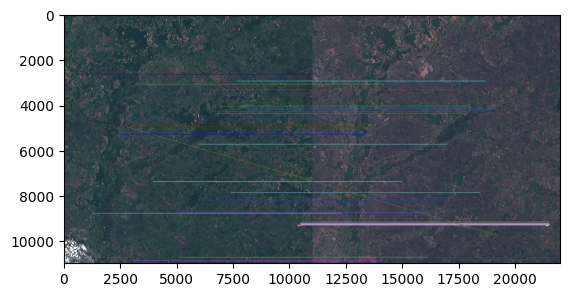

In [129]:
plt.imshow(res_img)
plt.show()

Let's try images of different areas. 

In [126]:
image0 = reshape_as_image(raster_images[0][0])
res_img = orb_match(image0, image1)

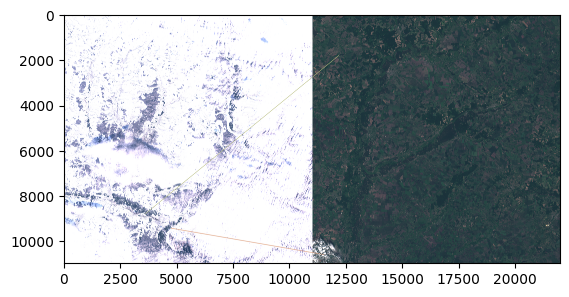

In [122]:
plt.imshow(res_img)
plt.show()

### Matching with LoFTR

LoFTR is better suited for matching images with significant seasonal differences, as it uses deep learning for better feature extraction.

In [48]:
pip install kornia kornia_moons

Note: you may need to restart the kernel to use updated packages.


In [24]:
import torch
import kornia

loftr = kornia.feature.LoFTR(pretrained="outdoor").eval().cuda()

/opt/conda/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /root/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt
100%|██████████| 44.2M/44.2M [00:04<00:00, 11.2MB/s]


In [137]:
def match_images_loftr(image1, image2):
    image1_gray = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY) / 255.0
    image2_gray = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY) / 255.0

    input_dict = {
        "image0": kornia.utils.image_to_tensor(image1_gray).float().unsqueeze(0).cuda(),
        "image1": kornia.utils.image_to_tensor(image2_gray).float().unsqueeze(0).cuda()
    }

    # Perform matching
    with torch.no_grad():
        correspondences = loftr(input_dict)

    keypoints1 = correspondences['keypoints0'].cpu().numpy()
    keypoints2 = correspondences['keypoints1'].cpu().numpy()

    try:
        Fm, inliers = cv2.findFundamentalMat(keypoints1, keypoints2, cv2.USAC_MAGSAC, 0.0009, 0.9999999, 100000)
        inliers = inliers > 0
    except:
        print("No matching points found.")
        return None, None, None
    
    return keypoints1, keypoints2, inliers

LoFTR struggles with extremely high-resolution images, so we downscale images to a manageable size.

In [53]:
def resize_img(img, max_dimension=1024):
    height, width = img.shape[:2]
    scale = max_dimension / max(height, width)
    resized_img = cv2.resize(img, (int(width * scale), int(height * scale)), interpolation=cv2.INTER_AREA)
    resized_img = resized_img.reshape(int(width * scale), int(height * scale), -1)
    return resized_img

In [54]:
res_image1 = resize_img(image1)
res_image2 = resize_img(image2)

In [55]:
keypoints1, keypoints2, inliers = match_images_loftr(res_image1, res_image2)

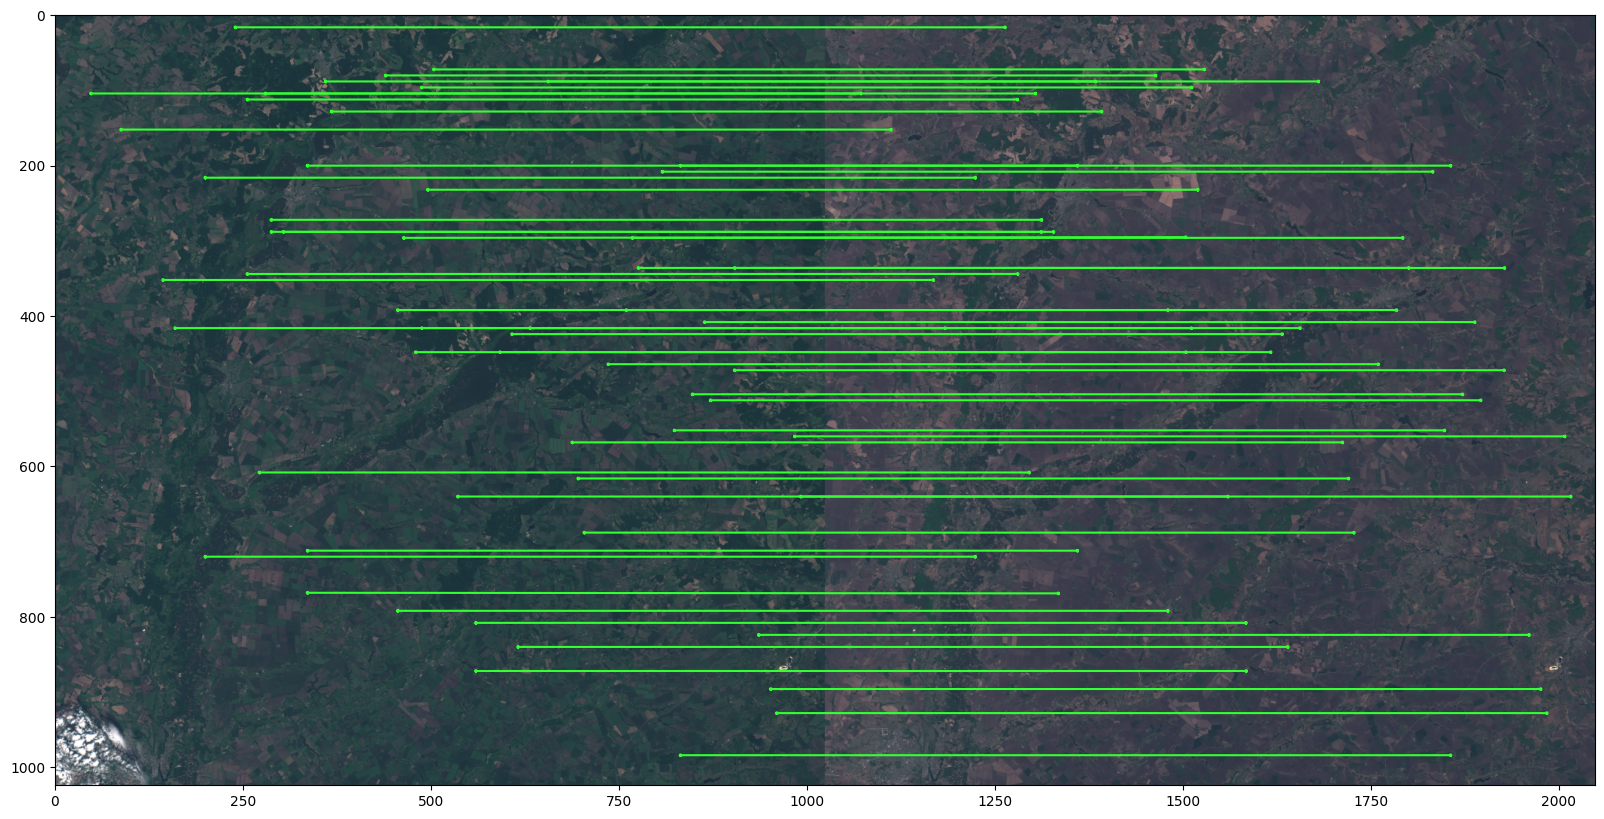

In [91]:
from kornia_moons.viz import draw_LAF_matches

draw_LAF_matches(
    kornia.feature.laf_from_center_scale_ori(
        torch.from_numpy(keypoints1).view(1, -1, 2),
        torch.ones(keypoints1.shape[0]).view(1, -1, 1, 1),
        torch.ones(keypoints1.shape[0]).view(1, -1, 1),
    ),
    kornia.feature.laf_from_center_scale_ori(
        torch.from_numpy(keypoints2).view(1, -1, 2),
        torch.ones(keypoints2.shape[0]).view(1, -1, 1, 1),
        torch.ones(keypoints2.shape[0]).view(1, -1, 1),
    ),
    torch.arange(keypoints1.shape[0]).view(-1, 1).repeat(1, 2),
    res_image1,
    res_image2,
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": None, "feature_color": None, "vertical": False},
)